In [1]:
import zipfile
%matplotlib inline
import numpy as np
import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import requests
import os
import geopandas as gpd
import matplotlib.pylab as pl
from fiona.crs import from_epsg
import fiona
import matplotlib.pylab as pl
from matplotlib import colors
import shapely
import seaborn as sns
from sklearn.cluster import KMeans
#add necessary libraries
import networkx as nx #library supporting networks
from shapely.geometry import Point, Polygon

In [2]:
fileUrl = 'https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=GeoJSON'
filebuffer = urllib.urlretrieve(fileUrl, filename='Data/Subway Stations.geojson')
fname = 'Subway Stations.geojson'
print (fname)
subStations = gpd.GeoDataFrame.from_file('Data/Subway Stations.geojson')

subStations.crs = from_epsg(4326)

Subway Stations.geojson


In [5]:
subStations.head(3)

geometry           line      name  \
0  POINT (-73.99106999861967 40.73005400028978)  4-6-6 Express  Astor Pl   
1  POINT (-74.00019299927328 40.71880300107709)  4-6-6 Express  Canal St   
2  POINT (-73.98384899986625 40.76172799961419)            1-2   50th St   

                                               notes objectid  \
0  4 nights, 6-all times, 6 Express-weekdays AM s...        1   
1  4 nights, 6-all times, 6 Express-weekdays AM s...        2   
2                              1-all times, 2-nights        3   

                                 url  
0  http://web.mta.info/nyct/service/  
1  http://web.mta.info/nyct/service/  
2  http://web.mta.info/nyct/service/

In [6]:
subStations.loc[subStations.name.duplicated(False)==True].name = subStations.loc[subStations.name.duplicated(False)==True].name + subStations.loc[subStations.name.duplicated(False)==True].line

In [8]:
print len(subStations.loc[subStations.name.duplicated(False)==True])
subStations.loc[subStations.name.duplicated(False)==True].head(3)

197


geometry           line       name  \
1  POINT (-74.00019299927328 40.71880300107709)  4-6-6 Express   Canal St   
2  POINT (-73.98384899986625 40.76172799961419)            1-2    50th St   
3  POINT (-73.97499915116808 40.68086213682956)          2-3-4  Bergen St   

                                               notes objectid  \
1  4 nights, 6-all times, 6 Express-weekdays AM s...        2   
2                              1-all times, 2-nights        3   
3           4-nights, 3-all other times, 2-all times        4   

                                 url  
1  http://web.mta.info/nyct/service/  
2  http://web.mta.info/nyct/service/  
3  http://web.mta.info/nyct/service/

In [9]:
subStations.loc[30,'name']

u'Grand Central - 42nd St'

In [10]:
subStations['nameduplicated'] = subStations.name.duplicated(False)
subStations['namemod'] = np.nan
for i in range(len(subStations)):
    if subStations.loc[i,'nameduplicated'] == True:
        subStations.loc[i,'namemod'] = subStations.loc[i,'name'] + ' - ' + subStations.loc[i,'line'].replace(' Express','')
    else:
        subStations.loc[i,'namemod'] = subStations.loc[i,'name']

In [11]:
subStations.head(3)

geometry           line      name  \
0  POINT (-73.99106999861967 40.73005400028978)  4-6-6 Express  Astor Pl   
1  POINT (-74.00019299927328 40.71880300107709)  4-6-6 Express  Canal St   
2  POINT (-73.98384899986625 40.76172799961419)            1-2   50th St   

                                               notes objectid  \
0  4 nights, 6-all times, 6 Express-weekdays AM s...        1   
1  4 nights, 6-all times, 6 Express-weekdays AM s...        2   
2                              1-all times, 2-nights        3   

                                 url nameduplicated           namemod  
0  http://web.mta.info/nyct/service/          False          Astor Pl  
1  http://web.mta.info/nyct/service/           True  Canal St - 4-6-6  
2  http://web.mta.info/nyct/service/           True     50th St - 1-2

In [12]:
for i in subStations.line:
    print i.replace(' Express','').split('-')
    print map(lambda x: x,i.replace(' Express','').split('-'))
    break

[u'4', u'6', u'6']
[u'4', u'6', u'6']


In [13]:
G=nx.Graph()
G.add_nodes_from(subStations.namemod)

In [14]:
def getXY(pt):
    return (pt.x, pt.y)

In [15]:
stationpos={}
subStations['longlat']= subStations.geometry.map(getXY)
for station in subStations.index:
    stationpos[subStations.namemod[station]]=subStations['longlat'][station]
    

In [17]:
fname = 'Data/CensusTracks.geojson'
tracks = gpd.GeoDataFrame.from_file(fname)
print tracks.crs 
tracks.head(3)

{}


boro_code boro_ct_2010      boro_name cdeligibil ct_2010 ctlabel  \
0         5      5000900  Staten Island          I  000900       9   
1         1      1009800      Manhattan          I  009800      98   
2         1      1010000      Manhattan          I  010000     100   

                                            geometry ntacode  \
0  (POLYGON ((-74.07920577013245 40.6434307837456...    SI22   
1  (POLYGON ((-73.96432543478758 40.7563815309909...    MN19   
2  (POLYGON ((-73.96802436915851 40.7595781400528...    MN19   

                                     ntaname  puma     shape_area  \
0  West New Brighton-New Brighton-St. George  3903  2497009.69813   
1                    Turtle Bay-East Midtown  3808  1906016.35002   
2                    Turtle Bay-East Midtown  3808  1860938.37721   

      shape_leng  
0  7729.01679376  
1  5534.19981063  
2  5692.16873705

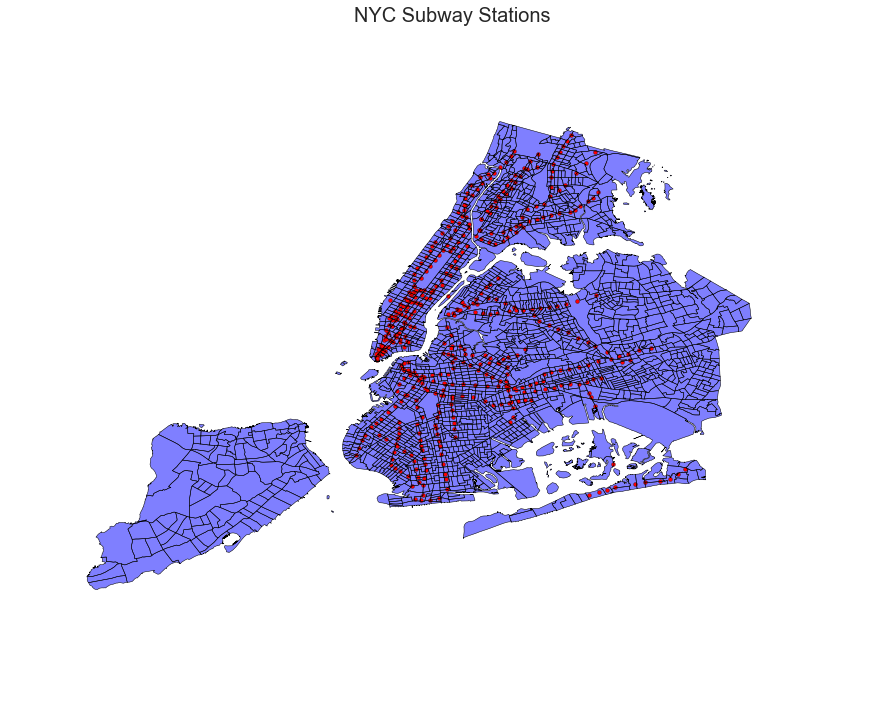

In [18]:
f, ax = pl.subplots(figsize=(15,12))

tracks.plot(c = 'k', linewidth = .5, ax = ax,  color= 'Blue')
pl.axis('off')

nx.draw(G,pos=stationpos,with_labels=False,arrows=True,node_size=15,style='dotted',edge_color='green')
pl.title("NYC Subway Stations", size=20)

In [19]:
for i in subStations.line:
    print i.replace(' Express','').split('-')
    print map(lambda x: x,i.replace(' Express','').split('-'))
    break

[u'4', u'6', u'6']
[u'4', u'6', u'6']


In [20]:
def getclosest(name):
    mask=[]
    for lines in subStations.line:
        if name in lines:
            mask.append(True)
        else:
            mask.append(False)
    distmat=np.empty((len(subStations[mask]),), dtype=float)
    print distmat.shape
    for stations in subStations[mask]['geometry']:
        distances=[]
        for other in subStations[mask]['geometry']:
            distances.append(stations.distance(other))
        #print len(distances)
        distmat = np.vstack((distmat,np.array(distances)))
    distmat = np.delete(distmat, 0, 0)
    print distmat.shape
    distmat
    for i in range(len(subStations[mask])):
        np.sort(distmat[i],kind='quicksort')[1]
        np.where( distmat[i] == np.sort(distmat[i],kind='quicksort')[1])[0][0]
        print subStations[mask].iloc[i]['namemod'], ',',str(subStations[mask].iloc[np.where( distmat[i] == np.sort(distmat[i],kind='quicksort')[1])[0][0]]['namemod'])

In [21]:
getclosest('L')

(24L,)
(24L, 24L)
Lorimer St - L , Graham Ave
Sutter Ave , Livonia Ave
Wilson Ave , Bushwick - Aberdeen
1st Ave , 3rd Ave
Grand St - L , Montrose Ave
Graham Ave , Grand St - L
Bedford Ave , Lorimer St - L
Montrose Ave , Grand St - L
Atlantic Ave , Broadway Junction - L
Halsey St - L , Wilson Ave
Myrtle - Wyckoff Aves - L , Halsey St - L
Livonia Ave , Sutter Ave
Canarsie - Rockaway Pkwy , E 105th St
E 105th St , Canarsie - Rockaway Pkwy
New Lots Ave - L , Livonia Ave
DeKalb Ave - L , Jefferson St
Bushwick - Aberdeen , Broadway Junction - L
Broadway Junction - L , Atlantic Ave
Jefferson St , DeKalb Ave - L
Morgan Ave , Montrose Ave
3rd Ave , 1st Ave
Union Sq - 14th St - L , 3rd Ave
6th Ave , 8th Ave - L
8th Ave - L , 6th Ave


RUSHhourLinks=[
    ('149th St - Grand Concourse - 4','125th St - 4-5-6-6'),###4
    ("E 180th St","3rd Ave - 149th St"),##5
    ('Nereid Ave (238 St)','233rd St'),
    ('233rd St','225th St'),
    ('225th St','219th St'),
    ('219th St','Gun Hill Rd - 2-5'),
    ('Gun Hill Rd - 2-5','Burke Ave'),
    ('Burke Ave','Allerton Ave'),
    ('Allerton Ave','Pelham Pkwy - 2-5'),
    ('Pelham Pkwy - 2-5','Bronx Park East'),
    ('Bronx Park East','E 180th St'), ###5
    ('Parkchester','Hunts Point Ave'),###6
    ('Hunts Point Ave','3rd Ave - 138th St'),###6
    ('Fordham Rd - B-D','Tremont Ave'),###D
    ('Tremont Ave','145th St - A-B-C-D')###D
    ]

LateNightLinks=[
    ('Grand St - B-D','DeKalb Ave - B-D-N-Q-R'),###D
    ('DeKalb Ave - B-D-N-Q-R',"Atlantic Av - Barclay's Center - D-N-Q-R"),###D
    ("Atlantic Av - Barclay's Center - D-N-Q-R",'Union St'),###D
    ('Union St','4th Av - 9th St - D-N-R'),###D
    ('4th Av - 9th St - D-N-R','Prospect Ave - D-N-R'),###D
    ('Prospect Ave - D-N-R','25th St'),###D
    ('25th St','36th St - D-N-R'),###D
    ('',''),
    ('',''),
    ('',''),
    ('',''),
    ('',''),
    ('','')
    ]
    


In [22]:
getclosest('7')

(22L,)
(22L, 22L)
Mets - Willets Point , 111th St - 7
Junction Blvd , 103rd St - Corona Plaza
Flushing - Main St , Mets - Willets Point
Woodside - 61st St , 69th St
Court Sq , Hunters Point Ave
Hunters Point Ave , Vernon Blvd - Jackson Ave
Vernon Blvd - Jackson Ave , Hunters Point Ave
Queensboro Plz , Court Sq
103rd St - Corona Plaza , Junction Blvd
111th St - 7 , 103rd St - Corona Plaza
Times Sq - 42nd St - 7-7 , 5th Ave - Bryant Pk
Grand Central - 42nd St - 7-7 , 5th Ave - Bryant Pk
69th St , 74th St - Broadway
74th St - Broadway , 69th St
52nd St , 46th St - 7
46th St - 7 , 40th St
82nd St - Jackson Hts , 90th St - Elmhurst Av
90th St - Elmhurst Av , 82nd St - Jackson Hts
33rd St - 7 , 40th St
40th St , 46th St - 7
5th Ave - Bryant Pk , Times Sq - 42nd St - 7-7
34th St - Hudson Yards , Times Sq - 42nd St - 7-7


In [23]:
sublines = ['G','N','R','Q','W','B','M','D','F','A','C','E','S','7','1','2','3','J','Z','L','4','5','6']

In [24]:
sublines.sort()
print sublines

['1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'W', 'Z']


In [25]:
Edges1=[
    ('Van Cortlandt Park - 242nd St','238th St'),
    ('238th St','231st St'),
    ('231st St','Marble Hill - 225th St'),
    ('Marble Hill - 225th St','215th St'),
    ('215th St','207th St'),
    ('207th St','Dyckman St - 1'),
    ('Dyckman St - 1','191st St'),
    ('191st St','181st St - 1'),
    ('181st St - 1','168th St - 1'),
    ('168th St - 1','157th St'),
    ('157th St','145th St - 1'),
    ('145th St - 1','137th St - City College'),
    ('137th St - City College','125th St - 1'),
    ('125th St - 1','116th St - Columbia University'),
    ('116th St - Columbia University','Cathedral Pkwy (110th St) - 1'),
    ('Cathedral Pkwy (110th St) - 1','103rd St - 1'),
    ('103rd St - 1','96th St - 1-2-3'),
    ('96th St - 1-2-3','86th St - 1-2'),
    ('86th St - 1-2','79th St - 1-2'),
    ('79th St - 1-2','72nd St - 1-2-3'),
    ('72nd St - 1-2-3','66th St - Lincoln Ctr'),
    ('66th St - Lincoln Ctr','59th St - Columbus Circle - 1-2'),
    ('59th St - Columbus Circle - 1-2','50th St - 1-2'),
    ('50th St - 1-2','Times Sq - 42nd St - 1-2-3'),
    ('Times Sq - 42nd St - 1-2-3','34th St - Penn Station - 1-2-3'),
    ('34th St - Penn Station - 1-2-3','28th St - 1-2'),
    ('28th St - 1-2','23rd St - 1-2'),
    ('23rd St - 1-2','18th St'),
    ('18th St','14th St - 1-2-3'),
    ('14th St - 1-2-3','Christopher St - Sheridan Sq'),
    ('Christopher St - Sheridan Sq','Houston St'),
    ('Houston St','Canal St - 1-2'),
    ('Canal St - 1-2','Franklin St'),
    ('Franklin St','Chambers St - 1-2-3'),
    ('Chambers St - 1-2-3','Rector St - 1'),
    #('Chambers St - 1-2-3','Cortlandt St - 1'), destroyed in 9/11
    #('Cortlandt St - 1','Rector St - 1'), destroyed in 9/11
    ('Rector St - 1','South Ferry')#ONLY THE FIRST 5 CARS CAN GET OFF AT SOUTH FERRY STATION
    ]

In [26]:
Edges2=[
    ('Wakefield - 241st St','Nereid Ave (238 St)'),
    ('Nereid Ave (238 St)','233rd St'),
    ('233rd St','225th St'),
    ('225th St','219th St'),
    ('219th St','Gun Hill Rd - 2-5'),
    ('Gun Hill Rd - 2-5','Burke Ave'),
    ('Burke Ave','Allerton Ave'),
    ('Allerton Ave','Pelham Pkwy - 2-5'),
    ('Pelham Pkwy - 2-5','Bronx Park East'),
    ('Bronx Park East','E 180th St'),
    ('E 180th St','West Farms Sq - E Tremont Av'),
    ('West Farms Sq - E Tremont Av','174th St'),
    ('174th St','Freeman St'),
    ('Freeman St','Simpson St'),
    ('Simpson St','Intervale Ave'),
    ('Intervale Ave','Prospect Ave - 2-5'),
    ('Prospect Ave - 2-5','Jackson Ave'),
    ('Jackson Ave','3rd Ave - 149th St'),
    ('3rd Ave - 149th St','149th St - Grand Concourse - 2-5'),
    ('149th St - Grand Concourse - 2-5','135th St - 2-3'),
    ('135th St - 2-3','125th St - 2-3'),
    ('125th St - 2-3','116th St - 2-3'),
    ('116th St - 2-3','Central Park North (110th St)'),
    ('Central Park North (110th St)','96th St - 1-2-3'),
    ('96th St - 1-2-3','72nd St - 1-2-3'),
    ('72nd St - 1-2-3','Times Sq - 42nd St - 1-2-3'),
    ('Times Sq - 42nd St - 1-2-3','34th St - Penn Station - 1-2-3'),
    ('34th St - Penn Station - 1-2-3','14th St - 1-2-3'),
    ('14th St - 1-2-3','Chambers St - 1-2-3'),
    ('Chambers St - 1-2-3','Park Pl - 2-3'),
    ('Park Pl - 2-3','Fulton St - 2-3'),
    ('Fulton St - 2-3','Wall St - 2-3'),
    ('Wall St - 2-3','Clark St'),
    ('Clark St','Borough Hall - 2-3'),
    ('Borough Hall - 2-3','Hoyt St'),
    ('Hoyt St','Nevins St'),
    ('Nevins St',"Atlantic Av - Barclay's Center - 2-3-4-5"),
    ("Atlantic Av - Barclay's Center - 2-3-4-5",'Bergen St - 2-3-4'),
    ('Bergen St - 2-3-4','Grand Army Plaza'),
    ('Grand Army Plaza','Eastern Pkwy - Bklyn Museum'),
    ('Eastern Pkwy - Bklyn Museum','Franklin Ave - 2-3-4-5'),
    ('Franklin Ave - 2-3-4-5','President St'),
    ('President St','Sterling St'),
    ('Sterling St','Winthrop St'),
    ('Winthrop St','Church Ave - 2-5'),
    ('Church Ave - 2-5','Beverly Rd - 2-5'),
    ('Beverly Rd - 2-5','Newkirk Ave - 2-5'),
    ('Newkirk Ave - 2-5','Brooklyn College - Flatbush Ave')    
    ]

In [27]:
Edges2LateNight=[
    ('96th St - 1-2-3','86th St - 1-2'),
    ('86th St - 1-2','79th St - 1-2'),
    ('72nd St - 1-2-3','66th St - Lincoln Ctr'),
    ('66th St - Lincoln Ctr','59th St - Columbus Circle - 1-2'),
    ('59th St - Columbus Circle - 1-2','50th St - 1-2'),
    ('50th St - 1-2','Times Sq - 42nd St - 1-2-3'), 
    ('34th St - Penn Station - 1-2-3','28th St - 1-2'),
    ('28th St - 1-2','23rd St - 1-2'), 
    ('23rd St - 1-2','18th St'), 
    ('18th St','14th St - 1-2-3'), 
    ('14th St - 1-2-3','Christopher St - Sheridan Sq'),
    ('Christopher St - Sheridan Sq','Houston St'), 
    ('Houston St','Canal St - 1-2'), 
    ('Canal St - 1-2','Franklin St'), 
    ('Franklin St','Chambers St - 1-2-3')
    ]

In [28]:
Edges3=[
    ('Harlem - 148 St','145th St - 3'),#First 5 cars to get off at 145 st
    ('145th St - 3','135th St - 2-3'),
    ('135th St - 2-3','125th St - 2-3'),
    ('125th St - 2-3','116th St - 2-3'),
    ('116th St - 2-3','Central Park North (110th St)'),
    ('Central Park North (110th St)','96th St - 1-2-3'),
    ('96th St - 1-2-3','72nd St - 1-2-3'),
    ('72nd St - 1-2-3','Times Sq - 42nd St - 1-2-3'),
    ('Times Sq - 42nd St - 1-2-3','34th St - Penn Station - 1-2-3'),
    ('34th St - Penn Station - 1-2-3','14th St - 1-2-3'),
    ('14th St - 1-2-3','Chambers St - 1-2-3'),
    ('Chambers St - 1-2-3','Park Pl - 2-3'),
    ('Park Pl - 2-3','Fulton St - 2-3'),
    ('Fulton St - 2-3','Wall St - 2-3'),
    ('Wall St - 2-3','Clark St'),
    ('Clark St','Borough Hall - 2-3'),
    ('Borough Hall - 2-3','Hoyt St'),
    ('Hoyt St','Nevins St'),
    ('Nevins St',"Atlantic Av - Barclay's Center - 2-3-4-5"),
    ("Atlantic Av - Barclay's Center - 2-3-4-5",'Bergen St - 2-3-4'),
    ('Bergen St - 2-3-4','Grand Army Plaza'),
    ('Grand Army Plaza','Eastern Pkwy - Bklyn Museum'),
    ('Eastern Pkwy - Bklyn Museum','Franklin Ave - 2-3-4-5'),
    ('Franklin Ave - 2-3-4-5','Nostrand Ave - 3-4'),
    ('Nostrand Ave - 3-4','Kingston Ave'),
    ('Kingston Ave','Crown Hts - Utica Ave'),
    ('Crown Hts - Utica Ave','Sutter Ave - Rutland Road'),
    ('Sutter Ave - Rutland Road','Saratoga Ave'),
    ('Saratoga Ave','Rockaway Ave - 3-4'),
    ('Rockaway Ave - 3-4','Junius St'),
    ('Junius St','Pennsylvania Ave'),
    ('Pennsylvania Ave','Van Siclen Ave - 3-4'),
    ('Van Siclen Ave - 3-4','New Lots Ave - 3-4')
    ]

In [29]:
Edges3LateNight=[
    ('Harlem - 148 St','145th St - 3'),#First 5 cars to get off at 145 st
    ('145th St - 3','135th St - 2-3'),
    ('135th St - 2-3','125th St - 2-3'),
    ('125th St - 2-3','116th St - 2-3'),
    ('116th St - 2-3','Central Park North (110th St)'),
    ('Central Park North (110th St)','96th St - 1-2-3'),
    ('96th St - 1-2-3','72nd St - 1-2-3'),
    ('72nd St - 1-2-3','Times Sq - 42nd St - 1-2-3'),
    ]

In [30]:
Edges4 = [
    ('Woodlawn','Mosholu Pkwy'),
    ('Mosholu Pkwy','Bedford Park Blvd - Lehman College'),
    ('Bedford Park Blvd - Lehman College','Kingsbridge Rd - 4'),
    ('Kingsbridge Rd - 4','Fordham Rd - 4'),
    ('Fordham Rd - 4','183rd St'),
    ('183rd St','Burnside Ave'),
    ('Burnside Ave','176th St'),
    ('176th St','Mt Eden Ave'),
    ('Mt Eden Ave','170th St - 4'),
    ('170th St - 4','167th St - 4'),
    ('167th St - 4','161st St - Yankee Stadium - 4'),
    ('161st St - Yankee Stadium - 4','149th St - Grand Concourse - 4'),
    #skipping the 138th station during rush hours
    ('149th St - Grand Concourse - 4','138th St - Grand Concourse'),
    ('138th St - Grand Concourse','125th St - 4-5-6-6'),
    ('125th St - 4-5-6-6','86th St - 4-5-6-6'),
    ('86th St - 4-5-6-6','Lexington Ave - 59th St - 4-5-6-6'),
    ('Lexington Ave - 59th St - 4-5-6-6','Grand Central - 42nd St - 4-5-6-6'),
    ('Grand Central - 42nd St - 4-5-6-6','Union Sq - 14th St - 4-5-6-6'),
    ('Union Sq - 14th St - 4-5-6-6','Brooklyn Bridge - City Hall'),
    ('Brooklyn Bridge - City Hall','Fulton St - 4-5'),
    ('Fulton St - 4-5','Wall St - 4-5'),
    ('Wall St - 4-5','Bowling Green'),
    ('Bowling Green','Borough Hall - 4-5'),
    ('Borough Hall - 4-5','Nevins St'),
    ('Nevins St',"Atlantic Av - Barclay's Center - 2-3-4-5"),
    ("Atlantic Av - Barclay's Center - 2-3-4-5",'Franklin Ave - 2-3-4-5'),
    ('Franklin Ave - 2-3-4-5','Crown Hts - Utica Ave')
    ]

In [31]:
Edges4RushHour=[
    ('Burnside Ave','167th St - 4'),
    ('149th St - Grand Concourse - 4','125th St - 4-5-6-6'),
    ]

In [32]:
Edges4LateNight=[
    ('125th St - 4-5-6-6' , '116th St - 4-6-6'),
    ('116th St - 4-6-6','110th St'),
    ('110th St','103rd St - 4-6-6'),
    ('103rd St - 4-6-6','96th St - 4-6-6'),
    ('96th St - 4-6-6','86th St - 4-5-6-6'),
    ('86th St - 4-5-6-6','77th St - 4-6-6'), 
    ('77th St - 4-6-6','68th St - Hunter College'),
    ('68th St - Hunter College','Lexington Ave - 59th St - 4-5-6-6'),
    ('Lexington Ave - 59th St - 4-5-6-6','51st St'),
    ('51st St','Grand Central - 42nd St - 4-5-6-6'),
    ('Grand Central - 42nd St - 4-5-6-6','33rd St - 4-6-6'),
    ('33rd St - 4-6-6','28th St - 4-6-6'),
    ('28th St - 4-6-6','23rd St - 4-6-6'),
    ('23rd St - 4-6-6','Union Sq - 14th St - 4-5-6-6'),
    ('Union Sq - 14th St - 4-5-6-6','Astor Pl'),
    ('Astor Pl','Bleecker St'),
    ('Bleecker St','Spring St - 4-6-6'),
    ('Spring St - 4-6-6','Canal St - 4-6-6'),
    ('Canal St - 4-6-6','Brooklyn Bridge - City Hall'),
    ("Atlantic Av - Barclay's Center - 2-3-4-5",'Bergen St - 2-3-4'),
    ('Bergen St - 2-3-4','Grand Army Plaza'),
    ('Grand Army Plaza','Eastern Pkwy - Bklyn Museum'),
    ('Eastern Pkwy - Bklyn Museum','Franklin Ave - 2-3-4-5'),
    ('Franklin Ave - 2-3-4-5','Nostrand Ave - 3-4'),
    ('Nostrand Ave - 3-4','Kingston Ave'),
    ('Kingston Ave','Crown Hts - Utica Ave'),
    ('Crown Hts - Utica Ave','Sutter Ave - Rutland Road'),
    ('Sutter Ave - Rutland Road','Saratoga Ave'),
    ('Saratoga Ave','Rockaway Ave - 3-4'),
    ('Rockaway Ave - 3-4','Junius St'),
    ('Junius St','Pennsylvania Ave'),
    ('Pennsylvania Ave','Van Siclen Ave - 3-4'),
    ('Van Siclen Ave - 3-4','New Lots Ave - 3-4')
    ]

In [33]:
#http://web.mta.info/nyct/service/pdf/t5cur.pdf
Edges5 = [
    ('Eastchester - Dyre Ave','Baychester Ave'),
    ('Baychester Ave','Gun Hill Rd - 5'),
    ('Gun Hill Rd - 5','Pelham Pkwy - 5'),
    ('Pelham Pkwy - 5','Morris Park'),
    ('Morris Park','E 180th St'),
    ####Bellow 
#Weekdays daytime, most 5 trains operate between either Dyre Av or 238 StNereid
#Av, Bronx, and Flatbush Av-Brooklyn College, Brooklyn. At all other
#times except during late nights, 5 trains operate between Dyre Av, Bronx, and
#Bowling Green, Manhattan. During late nights 5 trains operate only in the
#Bronx between Dyre Av and E 180 St/Morris Park Av. Customers who ride
#during late night hours can transfer to 2 service at the E 180 St Station.
#At all times, 5 trains operate express in Manhattan and Brooklyn. Weekdays,
#5 trains in the Bronx operate express from E 180 St to 3 Av-149 St during
#morning rush hours (from about 6 AM to 9 AM), and from 3 Av-149 St to
#E 180 St during the evening rush hours (from about 4 PM to 7 PM).
    ('E 180th St','West Farms Sq - E Tremont Av'),
    ('West Farms Sq - E Tremont Av','174th St'),
    ('174th St','Freeman St'),
    ('Freeman St','Simpson St'),
    ('Simpson St','Intervale Ave'),
    ('Intervale Ave','Prospect Ave - 2-5'),
    ('Prospect Ave - 2-5','Jackson Ave'),
    ('Jackson Ave','3rd Ave - 149th St'),
    ('3rd Ave - 149th St','138th St - Grand Concourse'),
    ('138th St - Grand Concourse','125th St - 4-5-6-6'),
    ('125th St - 4-5-6-6','86th St - 4-5-6-6'),
    ('86th St - 4-5-6-6','Lexington Ave - 59th St - 4-5-6-6'),
    ('Lexington Ave - 59th St - 4-5-6-6','Grand Central - 42nd St - 4-5-6-6'),
    ('Grand Central - 42nd St - 4-5-6-6','Union Sq - 14th St - 4-5-6-6'),
    ('Union Sq - 14th St - 4-5-6-6','Brooklyn Bridge - City Hall'),
    ('Brooklyn Bridge - City Hall','Fulton St - 4-5'),
    ('Fulton St - 4-5','Wall St - 4-5'),
    ('Wall St - 4-5','Bowling Green'),
    ('Bowling Green','Borough Hall - 4-5'),
    ('Borough Hall - 4-5','Nevins St'),
    ('Nevins St',"Atlantic Av - Barclay's Center - 2-3-4-5"),
    ("Atlantic Av - Barclay's Center - 2-3-4-5",'Franklin Ave - 2-3-4-5'),
    ('Franklin Ave - 2-3-4-5','President St'),
    ('President St','Sterling St'),
    ('Sterling St','Winthrop St'),
    ('Winthrop St','Church Ave - 2-5'),
    ('Church Ave - 2-5','Beverly Rd - 2-5'),
    ('Beverly Rd - 2-5','Newkirk Ave - 2-5'),
    ('Newkirk Ave - 2-5','Brooklyn College - Flatbush Ave')
    ]

In [34]:
Edges5RushHour = [
    ('Nereid Ave (238 St)','233rd St'),
    ('233rd St','225th St'),
    ('225th St','219th St'),
    ('219th St','Gun Hill Rd - 2-5'),
    ('Gun Hill Rd - 2-5','Burke Ave'),
    ('Burke Ave','Allerton Ave'),
    ('Allerton Ave','Pelham Pkwy - 2-5'),
    ('Pelham Pkwy - 2-5','Bronx Park East'),
    ('Bronx Park East','E 180th St')
    ]

In [35]:
#http://web.mta.info/nyct/service/pdf/t6cur.pdf
#6 local trains operate between Pelham Bay Park/Bruckner Expwy, Bronx, and
#Brooklyn Bridge/City Hall, Manhattan, at all times. Weekday mornings some
#6 trains (denoted below by a color bar) operate express toward Manhattan.
#Weekday afternoons and evenings, these trains operate express to the Bronx.
Edges6 = [
    ('Pelham Bay Park','Buhre Ave'),
    ('Buhre Ave','Middletown Rd'),
    ('Middletown Rd','Westchester Sq - E Tremont Ave'),
    ('Westchester Sq - E Tremont Ave','Zerega Ave'),
    ('Zerega Ave','Castle Hill Ave'),
    ('Castle Hill Ave','Parkchester'),
    ('Parkchester','St Lawrence Ave'),###express
    ('St Lawrence Ave','Morrison Av - Soundview'),
    ('Morrison Av - Soundview','Elder Ave'),
    ('Elder Ave','Whitlock Ave'),
    ('Whitlock Ave','Hunts Point Ave'),
    ('Hunts Point Ave','Longwood Ave'),###express
    ('Longwood Ave','E 149th St'),
    ("E 149th St","E 143rd St - St Mary's St"),
    ("E 143rd St - St Mary's St",'Cypress Ave'),
    ('Cypress Ave','Brook Ave'),
    ('Brook Ave','3rd Ave - 138th St'),
    ('3rd Ave - 138th St','125th St - 4-5-6-6'),
    ('125th St - 4-5-6-6','116th St - 4-6-6'),
    ('116th St - 4-6-6','110th St'),
    ('110th St','103rd St - 4-6-6'),
    ('103rd St - 4-6-6','96th St - 4-6-6'),
    ('96th St - 4-6-6','86th St - 4-5-6-6'),
    ('86th St - 4-5-6-6','77th St - 4-6-6'),
    ('77th St - 4-6-6','68th St - Hunter College'),
    ('68th St - Hunter College','Lexington Ave - 59th St - 4-5-6-6'),
    ('Lexington Ave - 59th St - 4-5-6-6','51st St'),
    ('51st St','Grand Central - 42nd St - 4-5-6-6'),
    ('Grand Central - 42nd St - 4-5-6-6','33rd St - 4-6-6'),
    ('33rd St - 4-6-6','28th St - 4-6-6'),
    ('28th St - 4-6-6','23rd St - 4-6-6'),
    ('23rd St - 4-6-6','Union Sq - 14th St - 4-5-6-6'),
    ('Union Sq - 14th St - 4-5-6-6','Astor Pl'),
    ('Astor Pl','Bleecker St'),
    ('Bleecker St','Spring St - 4-6-6'),
    ('Spring St - 4-6-6','Canal St - 4-6-6'),
    ('Canal St - 4-6-6','Brooklyn Bridge - City Hall')
    ]

In [36]:
Edges7=[
    ('Flushing - Main St','Mets - Willets Point'),
    ('Mets - Willets Point','111th St - 7'),
    ('111th St - 7','103rd St - Corona Plaza'),
    ('103rd St - Corona Plaza','Junction Blvd'),
    ('Junction Blvd','90th St - Elmhurst Av'),
    ('90th St - Elmhurst Av','82nd St - Jackson Hts'),
    ('82nd St - Jackson Hts','74th St - Broadway'),
    ('74th St - Broadway','69th St'),
    ('69th St','Woodside - 61st St'),
    ('Woodside - 61st St','52nd St'),
    ('52nd St','46th St - 7'),
    ('46th St - 7','40th St'),
    ('40th St','33rd St - 7'),
    ('33rd St - 7','Queensboro Plz'),
    ('Queensboro Plz','Court Sq'),
    ('Court Sq','Hunters Point Ave'),
    ('Hunters Point Ave','Vernon Blvd - Jackson Ave'),
    ('Vernon Blvd - Jackson Ave','Grand Central - 42nd St - 7-7'),
    ('Grand Central - 42nd St - 7-7','5th Ave - Bryant Pk'),
    ('5th Ave - Bryant Pk','Times Sq - 42nd St - 7-7'),
    ('Times Sq - 42nd St - 7-7','34th St - Hudson Yards')
    ]

In [37]:
#Train operates in one direction (To Manhattan AM, from Manhattan PM)
Edges7RushHour=[
    ('Queensboro Plz','Woodside - 61st St'),
    ('Woodside - 61st St','Junction Blvd'),
    ('Junction Blvd','Mets - Willets Point'),
]

In [38]:
EdgesA=[
    ('Inwood - 207th St', 'Dyckman St - A'),
    ('Dyckman St - A', '190th St'),
    ('190th St', '181st St - A'),
    ('181st St - A', '175th St'),
    ('175th St','168th St - A-C'),
    ('168th St - A-C','145th St - A-B-C-D'),
    ('145th St - A-B-C-D','125th St - A-B-C-D'),
    ('125th St - A-B-C-D','59th St - Columbus Circle - A-B-C-D'),
    ('59th St - Columbus Circle - A-B-C-D','42nd St - Port Authority Bus Term'), 
    ('42nd St - Port Authority Bus Term','34th St - Penn Station - A-C-E'),
    ('34th St - Penn Station - A-C-E','14th St - A-C-E'),
    ('14th St - A-C-E','W 4th St - Washington Sq (Upper)'),
    ('W 4th St - Washington Sq (Upper)','Canal St - Holland Tunnel'),
    ('Canal St - Holland Tunnel','Chambers St - A-C'),
    ('Chambers St - A-C','Fulton St - A-C'),
    ('Fulton St - A-C','High St'),
    ('High St','Jay St - MetroTech - A-C-F'),
    ('Jay St - MetroTech - A-C-F','Hoyt - Schermerhorn Sts'),
    ('Hoyt - Schermerhorn Sts','Nostrand Ave - A-C'),
    ('Nostrand Ave - A-C','Utica Ave'),
    ('Utica Ave','Broadway Junction - A-C'),
    ('Broadway Junction - A-C','Euclid Ave'),
    ('Euclid Ave','Grant Ave'),
    ('Grant Ave','80th St'),
    ('80th St','88th St'),
    ('88th St','Rockaway Blvd'),
    ('Rockaway Blvd','104th St'),
    ('104th St','111th St - A-S'),
    ('111th St - A-S','Ozone Park - Lefferts Blvd'),
    ('Rockaway Blvd','Aqueduct - North Conduit Av'),##one direction
    ('Aqueduct Racetrack','Rockaway Blvd'), ##one direction
    ('Aqueduct - North Conduit Av','Howard Beach - JFK Airport'),##one direction
    ('Howard Beach - JFK Airport','Aqueduct Racetrack'),##one direction
    ('Howard Beach - JFK Airport','Broad Channel'),
    ('Broad Channel','Beach 67th St'),
    ('Beach 67th St','Beach 60th St'),
    ('Beach 60th St','Beach 44th St'),
    ('Beach 44th St','Beach 36th St'),
    ('Beach 36th St','Beach 25th St'),
    ('Beach 25th St','Far Rockaway - Mott Ave'),
    ('Broad Channel','Beach 90th St'),
    ('Beach 90th St','Beach 98th St'),
    ('Beach 98th St','Beach 105th St'),
    ('Beach 105th St','Rockaway Park - Beach 116 St')]


In [39]:
getclosest('B')

(37L,)
(37L, 37L)
Cathedral Pkwy (110th St) - A-B-C , 116th St - A-B-C
DeKalb Ave - B-D-N-Q-R , Atlantic Av - Barclay's Center - B-Q
182nd-183rd Sts , Fordham Rd - B-D
174th-175th Sts , Tremont Ave
167th St - B-D , 170th St - B-D
72nd St - A-B-C , 81st St
96th St - A-B-C , 103rd St - A-B-C
Kingsbridge Rd - B-D , Fordham Rd - B-D
42nd St - Bryant Pk , Herald Sq - 34th St - B-D-F-M
Prospect Park , Church Ave - B-Q
W 4th St - Washington Sq (Lower) , Broadway - Lafayette St
Church Ave - B-Q , Prospect Park
Newkirk Ave - B-Q , Church Ave - B-Q
7th Ave - B-Q , Atlantic Av - Barclay's Center - B-Q
Atlantic Av - Barclay's Center - B-Q , DeKalb Ave - B-D-N-Q-R
103rd St - A-B-C , 96th St - A-B-C
81st St , 86th St - A-B-C
86th St - A-B-C , 81st St
Tremont Ave , 174th-175th Sts
170th St - B-D , 174th-175th Sts
Fordham Rd - B-D , 182nd-183rd Sts
Bedford Park Blvd , Kingsbridge Rd - B-D
145th St - A-B-C-D , 135th St - A-B-C
155th St - B-D , 145th St - A-B-C-D
161st St - Yankee Stadium - B-D , 167th 

In [40]:
EdgesB=[
    ('Bedford Park Blvd','Kingsbridge Rd - B-D'),
    ('Kingsbridge Rd - B-D','Fordham Rd - B-D'),
    ('Fordham Rd - B-D','182nd-183rd Sts'),
    ('182nd-183rd Sts','Tremont Ave'), 
    ('Tremont Ave','174th-175th Sts'),
    ('174th-175th Sts','170th St - B-D'),
    ('170th St - B-D','167th St - B-D'),
    ('167th St - B-D','161st St - Yankee Stadium - B-D'),
    ('161st St - Yankee Stadium - B-D','155th St - B-D'),
    ('155th St - B-D','145th St - A-B-C-D'),
    ('145th St - A-B-C-D','135th St - A-B-C'),
    ('135th St - A-B-C','125th St - A-B-C-D'),
    ('125th St - A-B-C-D','116th St - A-B-C'),
    ('116th St - A-B-C','Cathedral Pkwy (110th St) - A-B-C'),
    ('Cathedral Pkwy (110th St) - A-B-C','103rd St - A-B-C'), 
    ('103rd St - A-B-C','96th St - A-B-C'),
    ('96th St - A-B-C','86th St - A-B-C'),
    ('86th St - A-B-C','81st St'),
    ('81st St','72nd St - A-B-C'),
    ('72nd St - A-B-C','59th St - Columbus Circle - A-B-C-D'),
    ('59th St - Columbus Circle - A-B-C-D','7th Ave - B-D-E'),
    ('7th Ave - B-D-E','47th-50th Sts - Rockefeller Ctr'),
    ('47th-50th Sts - Rockefeller Ctr','42nd St - Bryant Pk'),
    ('42nd St - Bryant Pk','Herald Sq - 34th St - B-D-F-M'),
    ('Herald Sq - 34th St - B-D-F-M','W 4th St - Washington Sq (Lower)'),
    ('W 4th St - Washington Sq (Lower)','Broadway - Lafayette St'),
    ('Broadway - Lafayette St','Grand St - B-D'),
    ('Grand St - B-D',"DeKalb Ave - B-D-N-Q-R"),
    ('DeKalb Ave - B-D-N-Q-R',"Atlantic Av - Barclay's Center - B-Q"),
    ("Atlantic Av - Barclay's Center - B-Q",'7th Ave - B-Q'),
    ('7th Ave - B-Q','Prospect Park'),
    ('Prospect Park','Church Ave - B-Q'),
    ('Church Ave - B-Q','Newkirk Ave - B-Q'),
    ('Newkirk Ave - B-Q','Kings Hwy - B-Q'),
    ('Kings Hwy - B-Q','Sheepshead Bay'),  
    ('Sheepshead Bay','Brighton Beach') 
    ]

In [41]:
EdgesC=[
    ('168th St - A-C','163rd St - Amsterdam Av'),
    ('163rd St - Amsterdam Av','155th St - A-C'),
    ('155th St - A-C','145th St - A-B-C-D'),
    ('145th St - A-B-C-D','135th St - A-B-C'),
    ('135th St - A-B-C','125th St - A-B-C-D'),
    ('125th St - A-B-C-D','116th St - A-B-C'),
    ('116th St - A-B-C','Cathedral Pkwy (110th St) - A-B-C'),
    ('Cathedral Pkwy (110th St) - A-B-C','103rd St - A-B-C'),
    ('103rd St - A-B-C','96th St - A-B-C'),
    ('96th St - A-B-C','86th St - A-B-C'),
    ('86th St - A-B-C','81st St'),
    ('81st St','72nd St - A-B-C'),
    ('72nd St - A-B-C','59th St - Columbus Circle - A-B-C-D'),
    ('59th St - Columbus Circle - A-B-C-D','50th St - A-C-E'),
    ('50th St - A-C-E','42nd St - Port Authority Bus Term'),
    ('42nd St - Port Authority Bus Term','34th St - Penn Station - A-C-E'),
    ('34th St - Penn Station - A-C-E','23rd St - A-C-E'),
    ('23rd St - A-C-E','14th St - A-C-E'),
    ('14th St - A-C-E','W 4th St - Washington Sq (Upper)'),
    ('W 4th St - Washington Sq (Upper)','Spring St - A-C-E'),
    ('Spring St - A-C-E','Canal St - Holland Tunnel'),
    ('Canal St - Holland Tunnel','Chambers St - A-C'),
    ('Chambers St - A-C','Fulton St - A-C'),
    ('Fulton St - A-C','High St'),
    ('High St','Jay St - MetroTech - A-C-F'),
    ('Jay St - MetroTech - A-C-F','Hoyt - Schermerhorn Sts'),
    ('Hoyt - Schermerhorn Sts','Lafayette Ave'),
    ('Lafayette Ave','Clinton - Washington Aves - A-C'),
    ('Clinton - Washington Aves - A-C','Franklin Ave - A-C'),
    ('Franklin Ave - A-C','Nostrand Ave - A-C'),
    ('Nostrand Ave - A-C','Kingston - Throop Aves'),
    ('Kingston - Throop Aves','Utica Ave'),
    ('Utica Ave','Ralph Ave'),
    ('Ralph Ave','Rockaway Ave - A-C'),
    ('Rockaway Ave - A-C','Broadway Junction - A-C'),
    ('Broadway Junction - A-C','Liberty Ave'),
    ('Liberty Ave','Van Siclen Ave - A-C'),
    ('Van Siclen Ave - A-C','Shepherd Ave'),
    ('Shepherd Ave','Euclid Ave')
    ]

In [42]:
EdgesD=[
    ('Norwood - 205th St','Bedford Park Blvd'),
    ('Bedford Park Blvd','Kingsbridge Rd - B-D'),
    ('Kingsbridge Rd - B-D','Fordham Rd - B-D'),
    ('Fordham Rd - B-D','182nd-183rd Sts'),
    ('182nd-183rd Sts','Tremont Ave'), 
    ('Tremont Ave','174th-175th Sts'),
    ('174th-175th Sts','170th St - B-D'),
    ('170th St - B-D','167th St - B-D'),
    ('167th St - B-D','161st St - Yankee Stadium - B-D'),
    ('161st St - Yankee Stadium - B-D','155th St - B-D'),
    ('155th St - B-D','145th St - A-B-C-D'),
    ('145th St - A-B-C-D','125th St - A-B-C-D'), 
    ('125th St - A-B-C-D','59th St - Columbus Circle - A-B-C-D'),
    ('59th St - Columbus Circle - A-B-C-D','7th Ave - B-D-E'),
    ('7th Ave - B-D-E','47th-50th Sts - Rockefeller Ctr'),
    ('47th-50th Sts - Rockefeller Ctr','42nd St - Bryant Pk'),
    ('42nd St - Bryant Pk','Herald Sq - 34th St - B-D-F-M'),
    ('Herald Sq - 34th St - B-D-F-M','W 4th St - Washington Sq (Lower)'),
    ('W 4th St - Washington Sq (Lower)','Broadway - Lafayette St'),
    ('Broadway - Lafayette St','Grand St - B-D'),
    ('Grand St - B-D',"Atlantic Av - Barclay's Center - D-N-Q-R"),
    ("Atlantic Av - Barclay's Center - D-N-Q-R",'36th St - D-N-R'),
    ('36th St - D-N-R','9th Ave'),
    ('9th Ave','Ft Hamilton Pkwy - D'),
    ('Ft Hamilton Pkwy - D','50th St - D'),
    ('50th St - D','55th St'),
    ('55th St','62nd St'),
    ('62nd St','71st St'),
    ('71st St','79th St - D'),
    ('79th St - D','18th Ave - D'), 
    ('18th Ave - D','20th Ave - D'),
    ('20th Ave - D','Bay Pky - D'),
    ('Bay Pky - D','25th Ave'),
    ('25th Ave','Bay 50th St'),
    ('Bay 50th St','Coney Island - Stillwell Av'),
    ]

In [43]:
EdgesE = [
    ('Jamaica Ctr - Parsons / Archer','Sutphin Blvd - Archer Av'),
    ('Sutphin Blvd - Archer Av','Jamaica - Van Wyck'),
    ('Jamaica - Van Wyck','Briarwood - Van Wyck Blvd'),
    ('Briarwood - Van Wyck Blvd','Kew Gardens - Union Tpke'),
    ('Kew Gardens - Union Tpke','75th Ave'),
    ('75th Ave','Forest Hills - 71st Av'),
    ('Forest Hills - 71st Av','Jackson Hts - Roosevelt Av'),
    ('Jackson Hts - Roosevelt Av','Queens Plz'),
    ('Queens Plz','Court Sq - 23rd St'),
    ('Court Sq - 23rd St','Lexington Ave - 53rd St'),
    ('Lexington Ave - 53rd St','5th Ave - 53rd St'),
    ('5th Ave - 53rd St','7th Ave - B-D-E'),
    ('7th Ave - B-D-E','50th St - A-C-E'),
    ('50th St - A-C-E','42nd St - Port Authority Bus Term'),
    ('42nd St - Port Authority Bus Term','34th St - Penn Station - A-C-E'),
    ('34th St - Penn Station - A-C-E','23rd St - A-C-E'),
    ('23rd St - A-C-E','14th St - A-C-E'),
    ('14th St - A-C-E','W 4th St - Washington Sq (Upper)'),
    ('W 4th St - Washington Sq (Upper)','Spring St - A-C-E'),
    ('Spring St - A-C-E','Canal St - Holland Tunnel'),
    ('Canal St - Holland Tunnel','World Trade Center')
    ]

In [44]:
EdgesF=[
    ("Jamaica - 179th St","169th St"),
    ("169th St","Parsons Blvd"),
    ("Parsons Blvd","Sutphin Blvd"),
    ("Sutphin Blvd","Briarwood - Van Wyck Blvd"),
    ("Briarwood - Van Wyck Blvd","Kew Gardens - Union Tpke"),
    ("Kew Gardens - Union Tpke","75th Ave"),
    ("75th Ave","Forest Hills - 71st Av"),
    ("Forest Hills - 71st Av","Jackson Hts - Roosevelt Av"),
    ("Jackson Hts - Roosevelt Av","21st St - Queensbridge"),
    ("21st St - Queensbridge","Roosevelt Island - Main St"),
    ("Roosevelt Island - Main St","Lexington Ave - 63rd St"),
    ("Lexington Ave - 63rd St","57th St - F"),
    ("57th St - F","47th-50th Sts - Rockefeller Ctr"),
    ("47th-50th Sts - Rockefeller Ctr","42nd St - Bryant Pk"),
    ("42nd St - Bryant Pk","Herald Sq - 34th St - B-D-F-M"),
    ("Herald Sq - 34th St - B-D-F-M","23rd St - F-M"),
    ("23rd St - F-M","14th St - F-M"),
    ("14th St - F-M","W 4th St - Washington Sq (Lower)"),
    ("W 4th St - Washington Sq (Lower)","Broadway - Lafayette St"),
    ("Broadway - Lafayette St","Lower East Side - 2nd Ave"),
    ("Lower East Side - 2nd Ave","Delancey St - Essex St - F"),
    ("Delancey St - Essex St - F","East Broadway"),
    ("East Broadway","York St"),
    ("York St","Jay St - MetroTech - A-C-F"),
    ("Jay St - MetroTech - A-C-F","Bergen St - F-G"),
    ("Bergen St - F-G","Carroll St"),
    ("Carroll St","Smith - 9th Sts"),
    ("Smith - 9th Sts","4th Av - 9th St - F-G"),
    ("4th Av - 9th St - F-G","7th Ave - F-G"),
    ("7th Ave - F-G","15th St - Prospect Park"),
    ("15th St - Prospect Park","Ft Hamilton Pkwy - F-G"),
    ("Ft Hamilton Pkwy - F-G","Church Ave - F-G"),
    ("Church Ave - F-G","Ditmas Ave"),
    ("Ditmas Ave","18th Ave - F"),
    ("18th Ave - F","Ave I"),
    ("Ave I","Bay Pky - F"),
    ("Bay Pky - F","Ave N"),
    ("Ave N","Ave P"),
    ("Ave P","Kings Hwy - F"),
    ("Kings Hwy - F","Ave U - F"), 
    ("Ave U - F","Ave X"),
    ("Ave X","Neptune Ave"),
    ("Neptune Ave","W 8th St - NY Aquarium"),
    ('W 8th St - NY Aquarium','Coney Island - Stillwell Av')
    ]

In [45]:
EdgesG=[
    ('Long Island City - Court Sq','21st St'),
    ('21st St','Greenpoint Ave'),
    ('Greenpoint Ave','Nassau Ave'),
    ('Nassau Ave','Metropolitan Ave'),
    ('Metropolitan Ave','Broadway - G'),
    ('Broadway - G','Flushing Ave - G'),
    ('Flushing Ave - G','Myrtle-Willoughby Aves'),
    ('Myrtle-Willoughby Aves','Bedford - Nostrand Aves'),
    ('Bedford - Nostrand Aves','Classon Ave'),
    ('Classon Ave','Clinton - Washington Aves - G'),
    ('Clinton - Washington Aves - G','Fulton St - G'),
    ('Fulton St - G','Hoyt - Schermerhorn Sts'),
    ('Hoyt - Schermerhorn Sts','Bergen St - F-G'),
    ('Bergen St - F-G','Carroll St'),
    ('Carroll St','Smith - 9th Sts'),
    ('Smith - 9th Sts','4th Av - 9th St - F-G'),
    ('4th Av - 9th St - F-G','7th Ave - F-G'),
    ('7th Ave - F-G','15th St - Prospect Park'),
    ('15th St - Prospect Park','Ft Hamilton Pkwy - F-G'),
    ('Ft Hamilton Pkwy - F-G','Church Ave - F-G')
    ]

In [46]:
EdgesJ=[
    ('Broad St','Fulton St - J-Z'),
    ('Fulton St - J-Z','Chambers St - J-Z'),
    ('Chambers St - J-Z','Canal St - J-Z'),
    ('Canal St - J-Z','Bowery'),
    ('Bowery','Delancey St - Essex St - J-M-Z'),
    ('Delancey St - Essex St - J-M-Z','Marcy Ave'), 
    ('Marcy Ave','Hewes St'),
    ('Hewes St','Lorimer St - J-M'),#part time 
    ('Lorimer St - J-M','Flushing Ave - J-M'),#part time
    ('Flushing Ave - J-M','Myrtle Ave'),#part time
    ('Myrtle Ave','Kosciuszko St'),
    ('Kosciuszko St','Gates Ave'),
    ('Gates Ave','Halsey St - J'),#part time
    ('Halsey St - J','Chauncey St'),#part time
    ('Chauncey St','Broadway Junction - J-Z'),
    ('Broadway Junction - J-Z','Alabama Ave'),
    ('Alabama Ave','Van Siclen Ave - J-Z'),#part time
    ('Van Siclen Ave - J-Z','Cleveland St'),#part time
    ('Cleveland St','Norwood Ave'),#part time
    ('Norwood Ave','Crescent St'),#part time
    ('Crescent St','Cypress Hills'),
    ('Cypress Hills','75th St - Eldert Ln'),
    ('75th St - Eldert Ln','85th St - Forest Pky'),
    ('85th St - Forest Pky','Woodhaven Blvd'),
    ('Woodhaven Blvd','104th-102nd Sts'),
    ('104th-102nd Sts','111th St - J'),
    ('111th St - J','121st St'),
    ('121st St','Sutphin Blvd - Archer Av'),
    ('Sutphin Blvd - Archer Av','Jamaica Ctr - Parsons / Archer')
    ]

In [47]:
EdgesL=[
    ('8th Ave - L','6th Ave'),
    ('6th Ave','Union Sq - 14th St - L'),
    ('Union Sq - 14th St - L','3rd Ave'),
    ('3rd Ave','1st Ave'),
    ('1st Ave','Bedford Ave'),
    ('Bedford Ave','Lorimer St - L'),
    ('Lorimer St - L','Graham Ave'),
    ('Graham Ave','Grand St - L'),
    ('Grand St - L','Montrose Ave'),
    ('Montrose Ave','Morgan Ave'),
    ('Morgan Ave','Jefferson St'),
    ('Jefferson St','DeKalb Ave - L'),
    ('DeKalb Ave - L','Myrtle - Wyckoff Aves - L'),
    ('Myrtle - Wyckoff Aves - L','Halsey St - L'),
    ('Halsey St - L','Wilson Ave'),
    ('Wilson Ave','Bushwick - Aberdeen'),
    ('Bushwick - Aberdeen','Broadway Junction - L'),
    ('Broadway Junction - L','Atlantic Ave'),
    ('Atlantic Ave','Sutter Ave'),
    ('Sutter Ave','Livonia Ave'),
    ('Livonia Ave','New Lots Ave - L'),
    ('New Lots Ave - L','E 105th St'),
    ('E 105th St','Canarsie - Rockaway Pkwy')
    ]

In [48]:
EdgesM=[
    ('Middle Village - Metropolitan Ave','Fresh Pond Rd'),
    ('Fresh Pond Rd','Forest Ave'),
    ('Forest Ave','Seneca Ave'),
    ('Seneca Ave','Myrtle - Wyckoff Aves - M'),
    ('Myrtle - Wyckoff Aves - M','Knickerbocker Ave'),
    ('Knickerbocker Ave','Central Ave'),
    ('Central Ave','Myrtle Ave'),  
    ('Myrtle Ave','Flushing Ave - J-M'),
    ('Flushing Ave - J-M','Lorimer St - J-M'),  
    ('Lorimer St - J-M','Hewes St'),
    ('Hewes St','Marcy Ave'),
    ('Marcy Ave','Delancey St - Essex St - J-M-Z'),
    ("Delancey St - Essex St - J-M-Z","Broadway - Lafayette St"),
    ("Broadway - Lafayette St","W 4th St - Washington Sq (Lower)"),
    ("W 4th St - Washington Sq (Lower)","14th St - F-M"),
    ("14th St - F-M","23rd St - F-M"),
    ("23rd St - F-M","Herald Sq - 34th St - B-D-F-M"),
    ("Herald Sq - 34th St - B-D-F-M","42nd St - Bryant Pk"),
    ("42nd St - Bryant Pk","47th-50th Sts - Rockefeller Ctr"),
    ("47th-50th Sts - Rockefeller Ctr","5th Ave - 53rd St"),
    ("5th Ave - 53rd St","Lexington Ave - 53rd St"),
    ("Lexington Ave - 53rd St","Court Sq - 23rd St"),
    ("Court Sq - 23rd St","Queens Plz"),
    ("Queens Plz","36th St - E-M-R"),
    ("36th St - E-M-R","Steinway St"),
    ("Steinway St","46th St - E-M-R"),
    ("46th St - E-M-R","Northern Blvd"),
    ("Northern Blvd","65th St"),
    ("65th St","Jackson Hts - Roosevelt Av"),
    ("Jackson Hts - Roosevelt Av","Elmhurst Ave"),
    ("Elmhurst Ave","Grand Ave - Newtown"),
    ("Grand Ave - Newtown","Woodhaven Blvd - Queens Mall"),
    ("Woodhaven Blvd - Queens Mall","63rd Dr - Rego Park"),
    ("63rd Dr - Rego Park","67th Ave"),
    ("67th Ave","Forest Hills - 71st Av")    
    ]

In [49]:
EdgesN=[
    ("Coney Island - Stillwell Av","Gravesend - 86th St"),
    ("Gravesend - 86th St","Ave U - N"),
    ("Ave U - N","Kings Hwy - N"),
    ("Kings Hwy - N","Bay Pky - N"),
    ("Bay Pky - N","20th Ave - N"),
    ("20th Ave - N","18th Ave - N"),
    ("18th Ave - N","New Utrecht Ave"),
    ("New Utrecht Ave","Ft Hamilton Pkwy - N"),
    ("Ft Hamilton Pkwy - N","8th Ave - N"),
    ("8th Ave - N","59th St"),
    ("59th St","36th St - D-N-R"),
    ("36th St - D-N-R","Atlantic Av - Barclay's Center - D-N-Q-R"),
    ("Atlantic Av - Barclay's Center - D-N-Q-R","Canal St - N-Q"),
    ("Canal St - N-Q","Union Sq - 14th St - N-Q-R-W"),
    ("Union Sq - 14th St - N-Q-R-W","Herald Sq - 34th St - N-Q-R-W"),
    ("Herald Sq - 34th St - N-Q-R-W","Times Sq - 42nd St - N-Q-R-W"),
    ("Times Sq - 42nd St - N-Q-R-W","49th St"),
    ("49th St","57th St - N-Q-R-W"),
    ("57th St - N-Q-R-W","5th Ave - 59th St"),
    ("5th Ave - 59th St","Lexington Ave - 59th St - N-R-W"), 
    ("Lexington Ave - 59th St - N-R-W","Queensboro Plz"),
    ("Queensboro Plz","39th Ave"),
    ("39th Ave","36th Ave"), 
    ("36th Ave","Broadway - N-W"),
    ("Broadway - N-W","30th Ave"), 
    ("30th Ave","Astoria Blvd"),
    ("Astoria Blvd","Astoria - Ditmars Blvd")
    ]

In [50]:
EdgesQ=[
    ('96th St - Q','86th St - Q'),
    ('86th St - Q','72nd St - Q'),
    ('72nd St - Q','Lexington Ave - 63rd St'),
    ('Lexington Ave - 63rd St','57th St - N-Q-R-W'),
    ('57th St - N-Q-R-W','Times Sq - 42nd St - N-Q-R-W'),
    ('Times Sq - 42nd St - N-Q-R-W','Herald Sq - 34th St - N-Q-R-W'),
    ('Herald Sq - 34th St - N-Q-R-W','Union Sq - 14th St - N-Q-R-W'),
    ('Union Sq - 14th St - N-Q-R-W','Canal St - N-Q'), 
    ('Canal St - N-Q','DeKalb Ave - B-D-N-Q-R'),
    ('DeKalb Ave - B-D-N-Q-R',"Atlantic Av - Barclay's Center - B-Q"),
    ("Atlantic Av - Barclay's Center - B-Q",'7th Ave - B-Q'),
    ('7th Ave - B-Q','Prospect Park'),
    ('Prospect Park','Parkside Ave'),
    ('Parkside Ave','Church Ave - B-Q'),
    ('Church Ave - B-Q','Beverly Rd - Q'),
    ('Beverly Rd - Q','Cortelyou Rd'),
    ('Cortelyou Rd','Newkirk Ave - B-Q'),
    ('Newkirk Ave - B-Q','Ave H'),
    ('Ave H','Ave J'),
    ('Ave J','Ave M'),  
    ('Ave M','Kings Hwy - B-Q'),
    ('Kings Hwy - B-Q','Ave U - Q'),
    ('Ave U - Q','Neck Rd'),
    ('Neck Rd','Sheepshead Bay'),
    ('Sheepshead Bay','Brighton Beach'), 
    ('Brighton Beach','Ocean Pkwy'),
    ('Ocean Pkwy','W 8th St - NY Aquarium'),
    ('W 8th St - NY Aquarium','Coney Island - Stillwell Av')
    ]

In [51]:
EdgesR=[
    ('Bay Ridge - 95th St','86th St - R'), 
    ('86th St - R','77th St - R'),
    ('77th St - R','Bay Ridge Ave'),
    ('Bay Ridge Ave','59th St'),
    ('59th St','53rd St'),
    ('53rd St','45th St'),
    ('45th St','36th St - D-N-R'),
    ('36th St - D-N-R','25th St'),
    ('25th St','Prospect Ave - D-N-R'),
    ('Prospect Ave - D-N-R','4th Av - 9th St - D-N-R'),
    ('4th Av - 9th St - D-N-R','Union St'),
    ('Union St',"Atlantic Av - Barclay's Center - D-N-Q-R"),
    ("Atlantic Av - Barclay's Center - D-N-Q-R",'DeKalb Ave - B-D-N-Q-R'),
    ('DeKalb Ave - B-D-N-Q-R','Jay St - MetroTech - N-R'),
    ('Jay St - MetroTech - N-R','Court St'),
    ('Court St','Whitehall St'),
    ('Whitehall St','Rector St - R-W'),
    ('Rector St - R-W','Cortlandt St - R-W'),
    ('Cortlandt St - R-W','City Hall'),
    ('City Hall','Canal St - R-W'),
    ('Canal St - R-W','Prince St'),
    ('Prince St','8th St - NYU'),
    ('8th St - NYU','Union Sq - 14th St - N-Q-R-W'),
    ('Union Sq - 14th St - N-Q-R-W','23rd St - N-Q-R-W'),
    ('23rd St - N-Q-R-W','28th St - N-Q-R-W'),
    ('28th St - N-Q-R-W','Herald Sq - 34th St - N-Q-R-W'),
    ('Herald Sq - 34th St - N-Q-R-W','Times Sq - 42nd St - N-Q-R-W'),
    ('Times Sq - 42nd St - N-Q-R-W','49th St'),
    ('49th St','57th St - N-Q-R-W'),
    ('57th St - N-Q-R-W','5th Ave - 59th St'),
    ('5th Ave - 59th St','Lexington Ave - 59th St - N-R-W'),
    ('Lexington Ave - 59th St - N-R-W','Queens Plz'),
    ('Queens Plz','36th St - E-M-R'),
    ('36th St - E-M-R','Steinway St'),
    ('Steinway St','46th St - E-M-R'),
    ('46th St - E-M-R','Northern Blvd'), 
    ('Northern Blvd','65th St'),
    ('65th St','Jackson Hts - Roosevelt Av'),
    ('Jackson Hts - Roosevelt Av','Elmhurst Ave'),
    ('Elmhurst Ave','Grand Ave - Newtown'),
    ('Grand Ave - Newtown','Woodhaven Blvd - Queens Mall'),
    ('Woodhaven Blvd - Queens Mall','63rd Dr - Rego Park'),
    ('63rd Dr - Rego Park','67th Ave'),
    ('67th Ave','Forest Hills - 71st Av')
    ]

In [52]:
EdgesS=[
    ("Franklin Ave - Fulton St","Park Pl - S"),
    ("Park Pl - S","Botanic Garden"), 
    ("Botanic Garden","Prospect Park"),
    ("Times Sq - 42nd St - S","Grand Central - 42nd St - S"),
    ("Broad Channel","Beach 90th St"),
    ("Beach 90th St","Beach 98th St"),
    ("Beach 98th St","Beach 105th St"),
    ("Beach 105th St","Rockaway Park - Beach 116 St")
    ]

In [53]:
EdgesW=[
    ("Whitehall St","Rector St - R-W"),
    ("Rector St - R-W","Cortlandt St - R-W"),
    ("Cortlandt St - R-W","City Hall"),
    ("City Hall","Canal St - R-W"),
    ("Canal St - R-W","Prince St"),
    ("Prince St","8th St - NYU"),
    ("8th St - NYU","Union Sq - 14th St - N-Q-R-W"),
    ("Union Sq - 14th St - N-Q-R-W","23rd St - N-Q-R-W"),
    ("23rd St - N-Q-R-W","28th St - N-Q-R-W"),
    ("28th St - N-Q-R-W","Herald Sq - 34th St - N-Q-R-W"),
    ("Herald Sq - 34th St - N-Q-R-W","Times Sq - 42nd St - N-Q-R-W"),
    ("Times Sq - 42nd St - N-Q-R-W","49th St"),
    ("49th St","57th St - N-Q-R-W"),
    ("57th St - N-Q-R-W","5th Ave - 59th St"),
    ("5th Ave - 59th St","Lexington Ave - 59th St - N-R-W"), 
    ("Lexington Ave - 59th St - N-R-W","Queensboro Plz"),
    ("Queensboro Plz","39th Ave"),
    ("39th Ave","36th Ave"), 
    ("36th Ave","Broadway - N-W"),
    ("Broadway - N-W","30th Ave"), 
    ("30th Ave","Astoria Blvd"),
    ("Astoria Blvd","Astoria - Ditmars Blvd")
    ]

In [54]:
EdgesZ=[
    ('Broad St','Fulton St - J-Z'),
    ('Fulton St - J-Z','Chambers St - J-Z'),
    ('Chambers St - J-Z','Canal St - J-Z'),
    ('Canal St - J-Z','Bowery'),
    ('Bowery','Delancey St - Essex St - J-M-Z'),
    ('Delancey St - Essex St - J-M-Z','Marcy Ave'), 
    ("Marcy Ave","Myrtle Ave"),
    ("Myrtle Ave","Gates Ave"),
    ("Gates Ave","Chauncey St"),
    ("Chauncey St","Broadway Junction - J-Z"),
    ('Broadway Junction - J-Z','Alabama Ave'),
    ('Alabama Ave','Van Siclen Ave - J-Z'),#part time
    ('Van Siclen Ave - J-Z','Norwood Ave'),
    ('Norwood Ave','Crescent St'),#part time
    ("Crescent St","75th St - Eldert Ln"),
    ("75th St - Eldert Ln","Woodhaven Blvd"),
    ('Woodhaven Blvd','104th-102nd Sts'),
    ('104th-102nd Sts','121st St'),
    ("121st St","Sutphin Blvd - Archer Av"),
    ("Sutphin Blvd - Archer Av","Jamaica Ctr - Parsons / Archer")
    ]

In [55]:
EdgesTransfers=[
    ("4th Av - 9th St - D-N-R","4th Av - 9th St - F-G"),
    ("New Utrecht Ave","62nd St"),
    ("Myrtle - Wyckoff Aves - L","Myrtle - Wyckoff Aves - M"),
    #("Lexington Ave - 63rd St","59th St"),
    ("Jackson Hts - Roosevelt Av","74th St - Broadway"),
    ("Court Sq - 23rd St","Court Sq"),
    ("Lorimer St - L","Metropolitan Ave"),
    ("Union Sq - 14th St - 4-5-6-6","Union Sq - 14th St - L"),
    ("Union Sq - 14th St - N-Q-R-W","Union Sq - 14th St - L"),
    ("Union Sq - 14th St - N-Q-R-W","Union Sq - 14th St - 4-5-6-6"),
    ("Bleecker St","Broadway - Lafayette St"),
    ("Canal St - N-Q","Canal St - 4-6-6"),
    ("Canal St - 4-6-6","Canal St - J-Z"),
    ("Brooklyn Bridge - City Hall","Chambers St - J-Z"),
    ("42nd St - Bryant Pk","5th Ave - Bryant Pk"),
    ("Herald Sq - 34th St - B-D-F-M","Herald Sq - 34th St - N-Q-R-W"),
    ("Delancey St - Essex St - F","Delancey St - Essex St - J-M-Z"),
    ("South Ferry","Whitehall St"),
    ("14th St - A-C-E","8th Ave - L"),
    ("W 4th St - Washington Sq (Lower)","W 4th St - Washington Sq (Upper)"),
    ("Jay St - MetroTech - A-C-F","Jay St - MetroTech - N-R"),
    ("Franklin Ave - A-C","Franklin Ave - Fulton St"),
    ("Broadway Junction - A-C","Broadway Junction - J-Z"),
    ("Broadway Junction - A-C","Broadway Junction - L"),
    ("Broadway Junction - J-Z","Broadway Junction - L"),
    ("161st St - Yankee Stadium - 4","161st St - Yankee Stadium - B-D"),
    #("59th St","Lexington Ave - 59th St - N-R-W"),
    ("51st St","Lexington Ave - 53rd St"),
    ("Grand Central - 42nd St - 4-5-6-6","Grand Central - 42nd St - 7-7"),
    ("Grand Central - 42nd St - 4-5-6-6","Grand Central - 42nd St - S"),
    ("Grand Central - 42nd St - 7-7","Grand Central - 42nd St - S"),
    ("168th St - A-C","168th St - 1"),
    ("149th St - Grand Concourse - 2-5","149th St - Grand Concourse - 4"),#notsure
    ("59th St - Columbus Circle - A-B-C-D","59th St - Columbus Circle - 1-2"),
    ("Times Sq - 42nd St - 1-2-3","Times Sq - 42nd St - 7-7"),
    ("Times Sq - 42nd St - 1-2-3","Times Sq - 42nd St - N-Q-R-W"),
    ("Times Sq - 42nd St - 1-2-3","Times Sq - 42nd St - S"),
    ("Times Sq - 42nd St - 7-7","Times Sq - 42nd St - N-Q-R-W"),
    ("Times Sq - 42nd St - 7-7","Times Sq - 42nd St - S"),
    ("Times Sq - 42nd St - N-Q-R-W","Times Sq - 42nd St - S"),
    ("42nd St - Port Authority Bus Term","Times Sq - 42nd St - 1-2-3"),
    ("42nd St - Port Authority Bus Term","Times Sq - 42nd St - 7-7"),
    ("42nd St - Port Authority Bus Term","Times Sq - 42nd St - N-Q-R-W"),
    ("42nd St - Port Authority Bus Term","Times Sq - 42nd St - S"),
    ("149th St - Grand Concourse - 4","149th St - Grand Concourse - 2-5"),
    ("14th St - 1-2-3","6th Ave"),
    ("14th St - 1-2-3","14th St - F-M"),
    ("Park Pl - 2-3","Chambers St - A-C"),
    ("Park Pl - 2-3","World Trade Center"),
    ("Fulton St - 2-3","Fulton St - 4-5"),
    ("Fulton St - 2-3","Fulton St - A-C"),
    ("Fulton St - 2-3","Fulton St - J-Z"),
    ("Fulton St - 4-5","Fulton St - A-C"),
    ("Fulton St - 4-5","Fulton St - J-Z"),
    ("Fulton St - A-C","Fulton St - J-Z"),
    ("Borough Hall - 2-3","Borough Hall - 4-5"),
    ("Borough Hall - 4-5","Court St"),
    ("Atlantic Av - Barclay's Center - 2-3-4-5","Atlantic Av - Barclay's Center - B-Q"),
    ("Atlantic Av - Barclay's Center - 2-3-4-5","Atlantic Av - Barclay's Center - D-N-Q-R"),
    ("Atlantic Av - Barclay's Center - B-Q","Atlantic Av - Barclay's Center - D-N-Q-R"),
    ("Franklin Ave - 2-3-4-5","Botanic Garden"),
    ("Botanic Garden","Prospect Park")
    ]

In [56]:
print sublines

['1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'W', 'Z']


In [57]:
consublines = [Edges1, Edges2, Edges3, Edges4, Edges5, Edges6, Edges7,
               EdgesA, EdgesB, EdgesC, EdgesD, EdgesE, EdgesF, EdgesG,
               EdgesJ, EdgesL, EdgesM, EdgesN, EdgesQ, EdgesR, EdgesS,
               EdgesW, EdgesZ, Edges4RushHour, Edges5RushHour,
               Edges7RushHour, EdgesTransfers]

In [58]:
G=nx.Graph()
for line in consublines:
    for edge in line:
        G.add_edge(edge[0],edge[1])

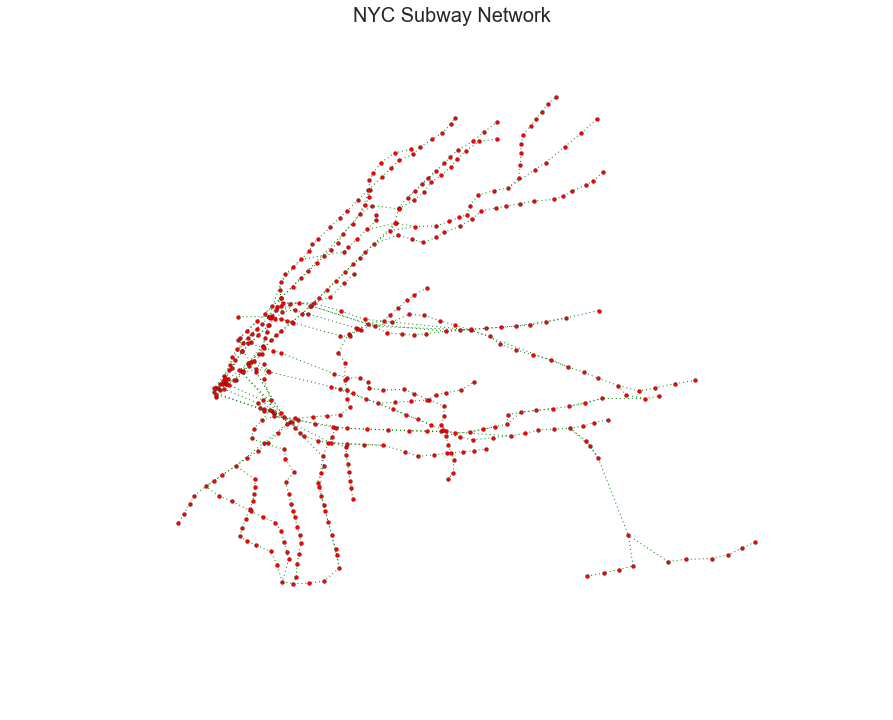

In [59]:
f, ax = pl.subplots(figsize=(15,12))
pl.axis('off')

nx.draw(G,pos=stationpos,with_labels=False,arrows=True,node_size=15,style='dotted',edge_color='green')
pl.title("NYC Subway Network", size=20)

In [65]:
nodes = G.nodes()
nodes.sort()

In [66]:
len(G.node)

472

In [67]:
len(subStations)

473

In [68]:
listtotest=[]
for i in range(len(G.node)):
    listtotest.append(G.node.items()[i][0])

In [69]:
for i in range(len(subStations)):
    if list(subStations.namemod)[i] in listtotest:
        pass
    else:
        print list(subStations.namemod)[i]

Cortlandt St - 1


nx.closeness_centrality(G, u=None, distance=None)

In [71]:
sum(list(zip(*nx.single_source_shortest_path_length(G,'Ave X').items())[1]))/len(list(zip(*nx.single_source_shortest_path_length(G,'Ave X').items())[1]))

18

In [72]:
len(list(zip(*nx.single_source_shortest_path_length(G,'Astor Pl').items())[1]))

472

In [73]:
sum(list(zip(*nx.single_source_shortest_path_length(G,'Astor Pl').items())[1]))/len(list(zip(*nx.single_source_shortest_path_length(G,'Astor Pl').items())[1]))

9

In [74]:
ConnectivityList = []
for node in subStations.namemod:
    if node!='Cortlandt St - 1':
        ConnectivityList.append(sum(list(zip(*nx.single_source_shortest_path_length(G,node).items())[1]))/len(G.node))
    else:
        ConnectivityList.append(np.nan)
    #print nodeb  

In [75]:
subStations['AverageShortestPath'] = ConnectivityList

In [76]:
len(nx.single_source_shortest_path_length(G,'Ave X').items())

472

In [77]:
ConnectivityList = []
for node in subStations.namemod:
    if node!='Cortlandt St - 1':
        if len(list(zip(*nx.single_source_shortest_path_length(G,node).items())[1])) != 472:
            print 'Error'

In [79]:
subStations.head(3)

geometry           line      name  \
0  POINT (-73.99106999861967 40.73005400028978)  4-6-6 Express  Astor Pl   
1  POINT (-74.00019299927328 40.71880300107709)  4-6-6 Express  Canal St   
2  POINT (-73.98384899986625 40.76172799961419)            1-2   50th St   

                                               notes objectid  \
0  4 nights, 6-all times, 6 Express-weekdays AM s...        1   
1  4 nights, 6-all times, 6 Express-weekdays AM s...        2   
2                              1-all times, 2-nights        3   

                                 url nameduplicated           namemod  \
0  http://web.mta.info/nyct/service/          False          Astor Pl   
1  http://web.mta.info/nyct/service/           True  Canal St - 4-6-6   
2  http://web.mta.info/nyct/service/           True     50th St - 1-2   

                           longlat  AverageShortestPath  
0  (-73.9910699986, 40.7300540003)                  9.0  
1  (-74.0001929993, 40.7188030011)                  9.0  
2  (-73.9838489999, 40.7617279996)                 10.0

In [80]:
subStations.AverageShortestPath.max()

29.0

In [81]:
subStations.AverageShortestPath.min()

8.0

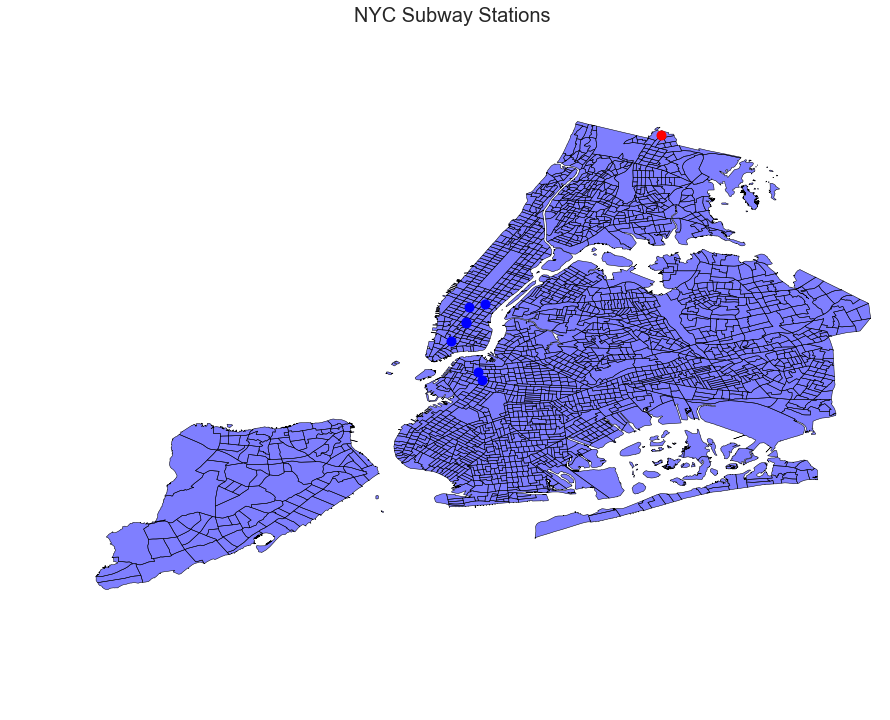

In [83]:
f, ax = pl.subplots(figsize=(15,12))
pl.axis('off')
tracks.plot(c = 'k', linewidth = .5, ax = ax,  color= 'Blue')
subStations[subStations.AverageShortestPath==29].plot(marker='o', markersize=10, linewidth = 4, c='r', ax = ax)
subStations[subStations.AverageShortestPath==8].plot(marker='o', markersize=10, linewidth = 4, c='b', ax = ax)
pl.title("NYC Subway Stations", size=20)

In [86]:
subStations[subStations.AverageShortestPath==8].name

14                         DeKalb Ave
30            Grand Central - 42nd St
104                Union Sq - 14th St
121    Atlantic Av - Barclay's Center
144               Herald Sq - 34th St
378                Union Sq - 14th St
434                          Canal St
Name: name, dtype: object

In [87]:
subStations['ConnectivityScore'] = (29-(subStations.AverageShortestPath-1))

In [88]:
subStations.head(3)

geometry           line      name  \
0  POINT (-73.99106999861967 40.73005400028978)  4-6-6 Express  Astor Pl   
1  POINT (-74.00019299927328 40.71880300107709)  4-6-6 Express  Canal St   
2  POINT (-73.98384899986625 40.76172799961419)            1-2   50th St   

                                               notes objectid  \
0  4 nights, 6-all times, 6 Express-weekdays AM s...        1   
1  4 nights, 6-all times, 6 Express-weekdays AM s...        2   
2                              1-all times, 2-nights        3   

                                 url nameduplicated           namemod  \
0  http://web.mta.info/nyct/service/          False          Astor Pl   
1  http://web.mta.info/nyct/service/           True  Canal St - 4-6-6   
2  http://web.mta.info/nyct/service/           True     50th St - 1-2   

                           longlat  AverageShortestPath  ConnectivityScore  
0  (-73.9910699986, 40.7300540003)                  9.0               21.0  
1  (-74.0001929993, 40.7188030011)                  9.0               21.0  
2  (-73.9838489999, 40.7617279996)                 10.0               20.0

In [89]:
with open('Data/Subway Stations.geojson', 'w') as f:
    f.write(subStations.to_json())

In [90]:
stationsBuffer = gpd.GeoDataFrame.from_file('Data/10min_Walkingdist_tosubway.geojson')

In [91]:
stationsBuffer.head(3)

geometry id           line  \
0  POLYGON ((-73.987312 40.737942, -73.986885 40....  0  4-6-6 Express   
1  POLYGON ((-73.99324799999999 40.724442, -73.99...  1  4-6-6 Express   
2  POLYGON ((-73.980576 40.76915, -73.980515 40.7...  2            1-2   

       name                                              notes objectid  \
0  Astor Pl  4 nights, 6-all times, 6 Express-weekdays AM s...        1   
1  Canal St  4 nights, 6-all times, 6 Express-weekdays AM s...        2   
2   50th St                              1-all times, 2-nights        3   

                                 url  
0  http://web.mta.info/nyct/service/  
1  http://web.mta.info/nyct/service/  
2  http://web.mta.info/nyct/service/

In [92]:
listings = gpd.GeoDataFrame.from_file('Data/NYClisting.geojson')

In [93]:
listings.head(3)
    

Median_income Median_rent  accesstosubway  availability_365  beer_count  \
0         21855        1287        8.368050               242           0   
1         21855        1287        8.380864               365           0   
2         21855        1287        8.406552               336           0   

  boro_ct_2010  calculated_host_listings_count  coffee_count  \
0      2002400                              10             0   
1      2000200                              10             0   
2      2000200                              10             0   

   connectivityScore                                      geometry  \
0                0.0  POINT (-73.86406089014145 40.81274651012037)   
1                0.0  POINT (-73.86381389361847 40.81293405229447)   
2                0.0  POINT (-73.86370502873359 40.81359965937455)   

       ...        latitude  longitude minimum_nights  \
0      ...       40.812747 -73.864061              2   
1      ...       40.812934 -73.863814              2   
2      ...       40.813600 -73.863705              1   

                                                name neighbourhood  \
0   Community Living in the Heart & Soul of NYC (3C)  Clason Point   
1       Private Room for 2, Community House NYC (2A)  Clason Point   
2  King sized bed + futon in Large Private Room  ...  Clason Point   

   neighbourhood_group  number_of_reviews  price reviews_per_month  \
0                Bronx                  9     59              1.53   
1                Bronx                  2     43              0.42   
2                Bronx                  6     76              1.37   

      room_type  
0  Private room  
1  Private room  
2  Private room  

[3 rows x 25 columns]

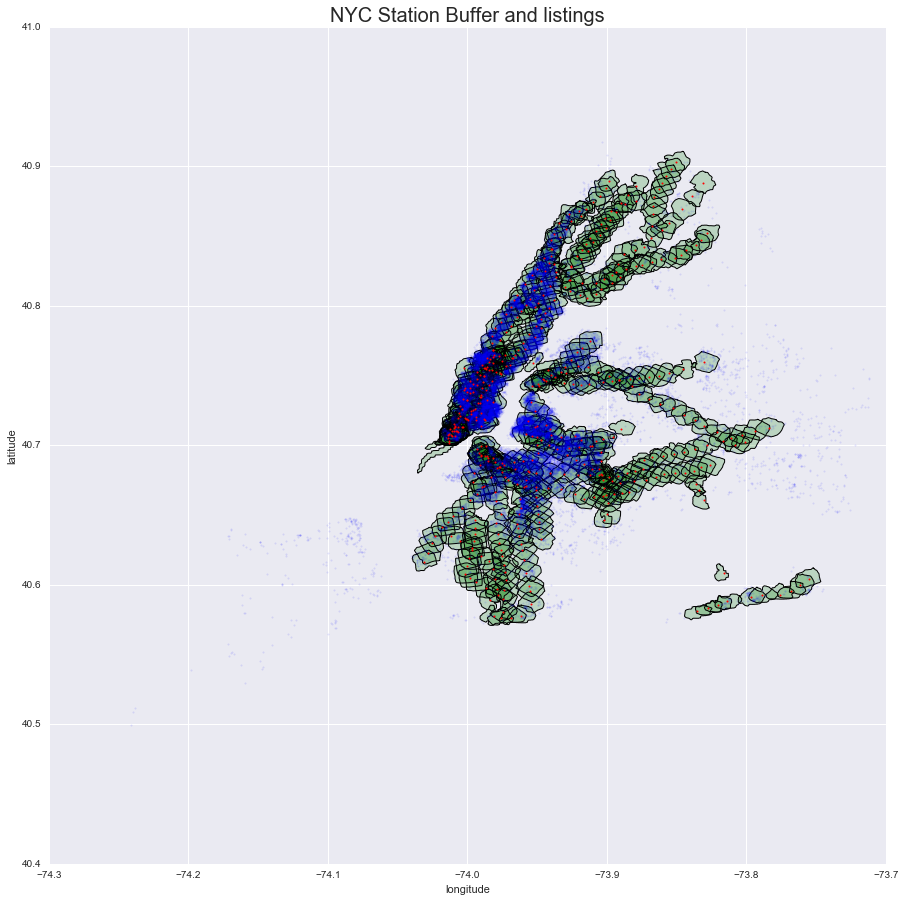

In [94]:
f, ax = pl.subplots(figsize=(15,15))

stationsBuffer.plot(linewidth = 1, color = 'g', ax = ax, alpha=.2)
listings.plot(marker='o', markersize=2, linewidth = 4, c='b', ax = ax, alpha=.1)
subStations.plot(marker='o', markersize=2, linewidth = 4, c='r', ax = ax)
pl.xlabel('longitude')
pl.ylabel('latitude')
#pl.ylim(40.6, 40.8)
#pl.xlim(-74.05, -73.85)
#ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("NYC Station Buffer and listings", size=20)

In [95]:
listings['connectivityScore'] = np.nan
connectivityScore = []
for airbnb in listings.geometry:
    mask = []
    for thebuffer in stationsBuffer.geometry:
        if airbnb.within(thebuffer):
            mask.append(True)
        else:
            mask.append(False)
    connectivityScore.append(subStations.ConnectivityScore[mask].sum())  
len(connectivityScore)

40586

In [96]:
listings['connectivityScore'] = connectivityScore

In [97]:
with open('Data/NYClisting.geojson', 'w') as f:
    f.write(listings.to_json())

In [98]:
listings['connectivityScore'].max()

394.0

In [99]:
listings['connectivityScore'].mean()

79.14830237027546

In [100]:
listings['connectivityScore'].min()

0.0

In [101]:
listings[listings['connectivityScore']==396.0]

Empty GeoDataFrame
Columns: [Median_income, Median_rent, accesstosubway, availability_365, beer_count, boro_ct_2010, calculated_host_listings_count, coffee_count, connectivityScore, geometry, host_id, host_name, id, index_left, last_review, latitude, longitude, minimum_nights, name, neighbourhood, neighbourhood_group, number_of_reviews, price, reviews_per_month, room_type]
Index: []

[0 rows x 25 columns]

In [111]:
listings[listings['connectivityScore']==0].count()

Median_income                     2507
Median_rent                       2507
accesstosubway                    2683
availability_365                  2683
beer_count                        2683
boro_ct_2010                      2679
calculated_host_listings_count    2683
coffee_count                      2683
connectivityScore                 2683
geometry                          2683
host_id                           2683
host_name                         2682
id                                2683
index_left                        2507
last_review                       2027
latitude                          2683
longitude                         2683
minimum_nights                    2683
name                              2682
neighbourhood                     2683
neighbourhood_group               2683
number_of_reviews                 2683
price                             2683
reviews_per_month                 2027
room_type                         2683
dtype: int64

In [103]:
import shapely as shp
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import geopandas as gpd
import seaborn as sns


In [104]:
fname = 'Data/tracks_listing_households.geojson'
tracks = gpd.GeoDataFrame.from_file(fname)
print tracks.crs

{}


In [105]:
totalshape = tracks.geometry[1]
for shape in tracks.geometry:
    totalshape = totalshape.union(shape)

In [106]:
totalshape

In [107]:
un = totalshape.envelope.symmetric_difference(totalshape)
un

In [108]:
gdf = gpd.GeoDataFrame.from_file('Data/NYClisting.geojson')
gdf.head()
df = gdf[['latitude','longitude']]
coords = gdf.as_matrix(columns=['latitude','longitude'])

In [109]:
from descartes import PolygonPatch

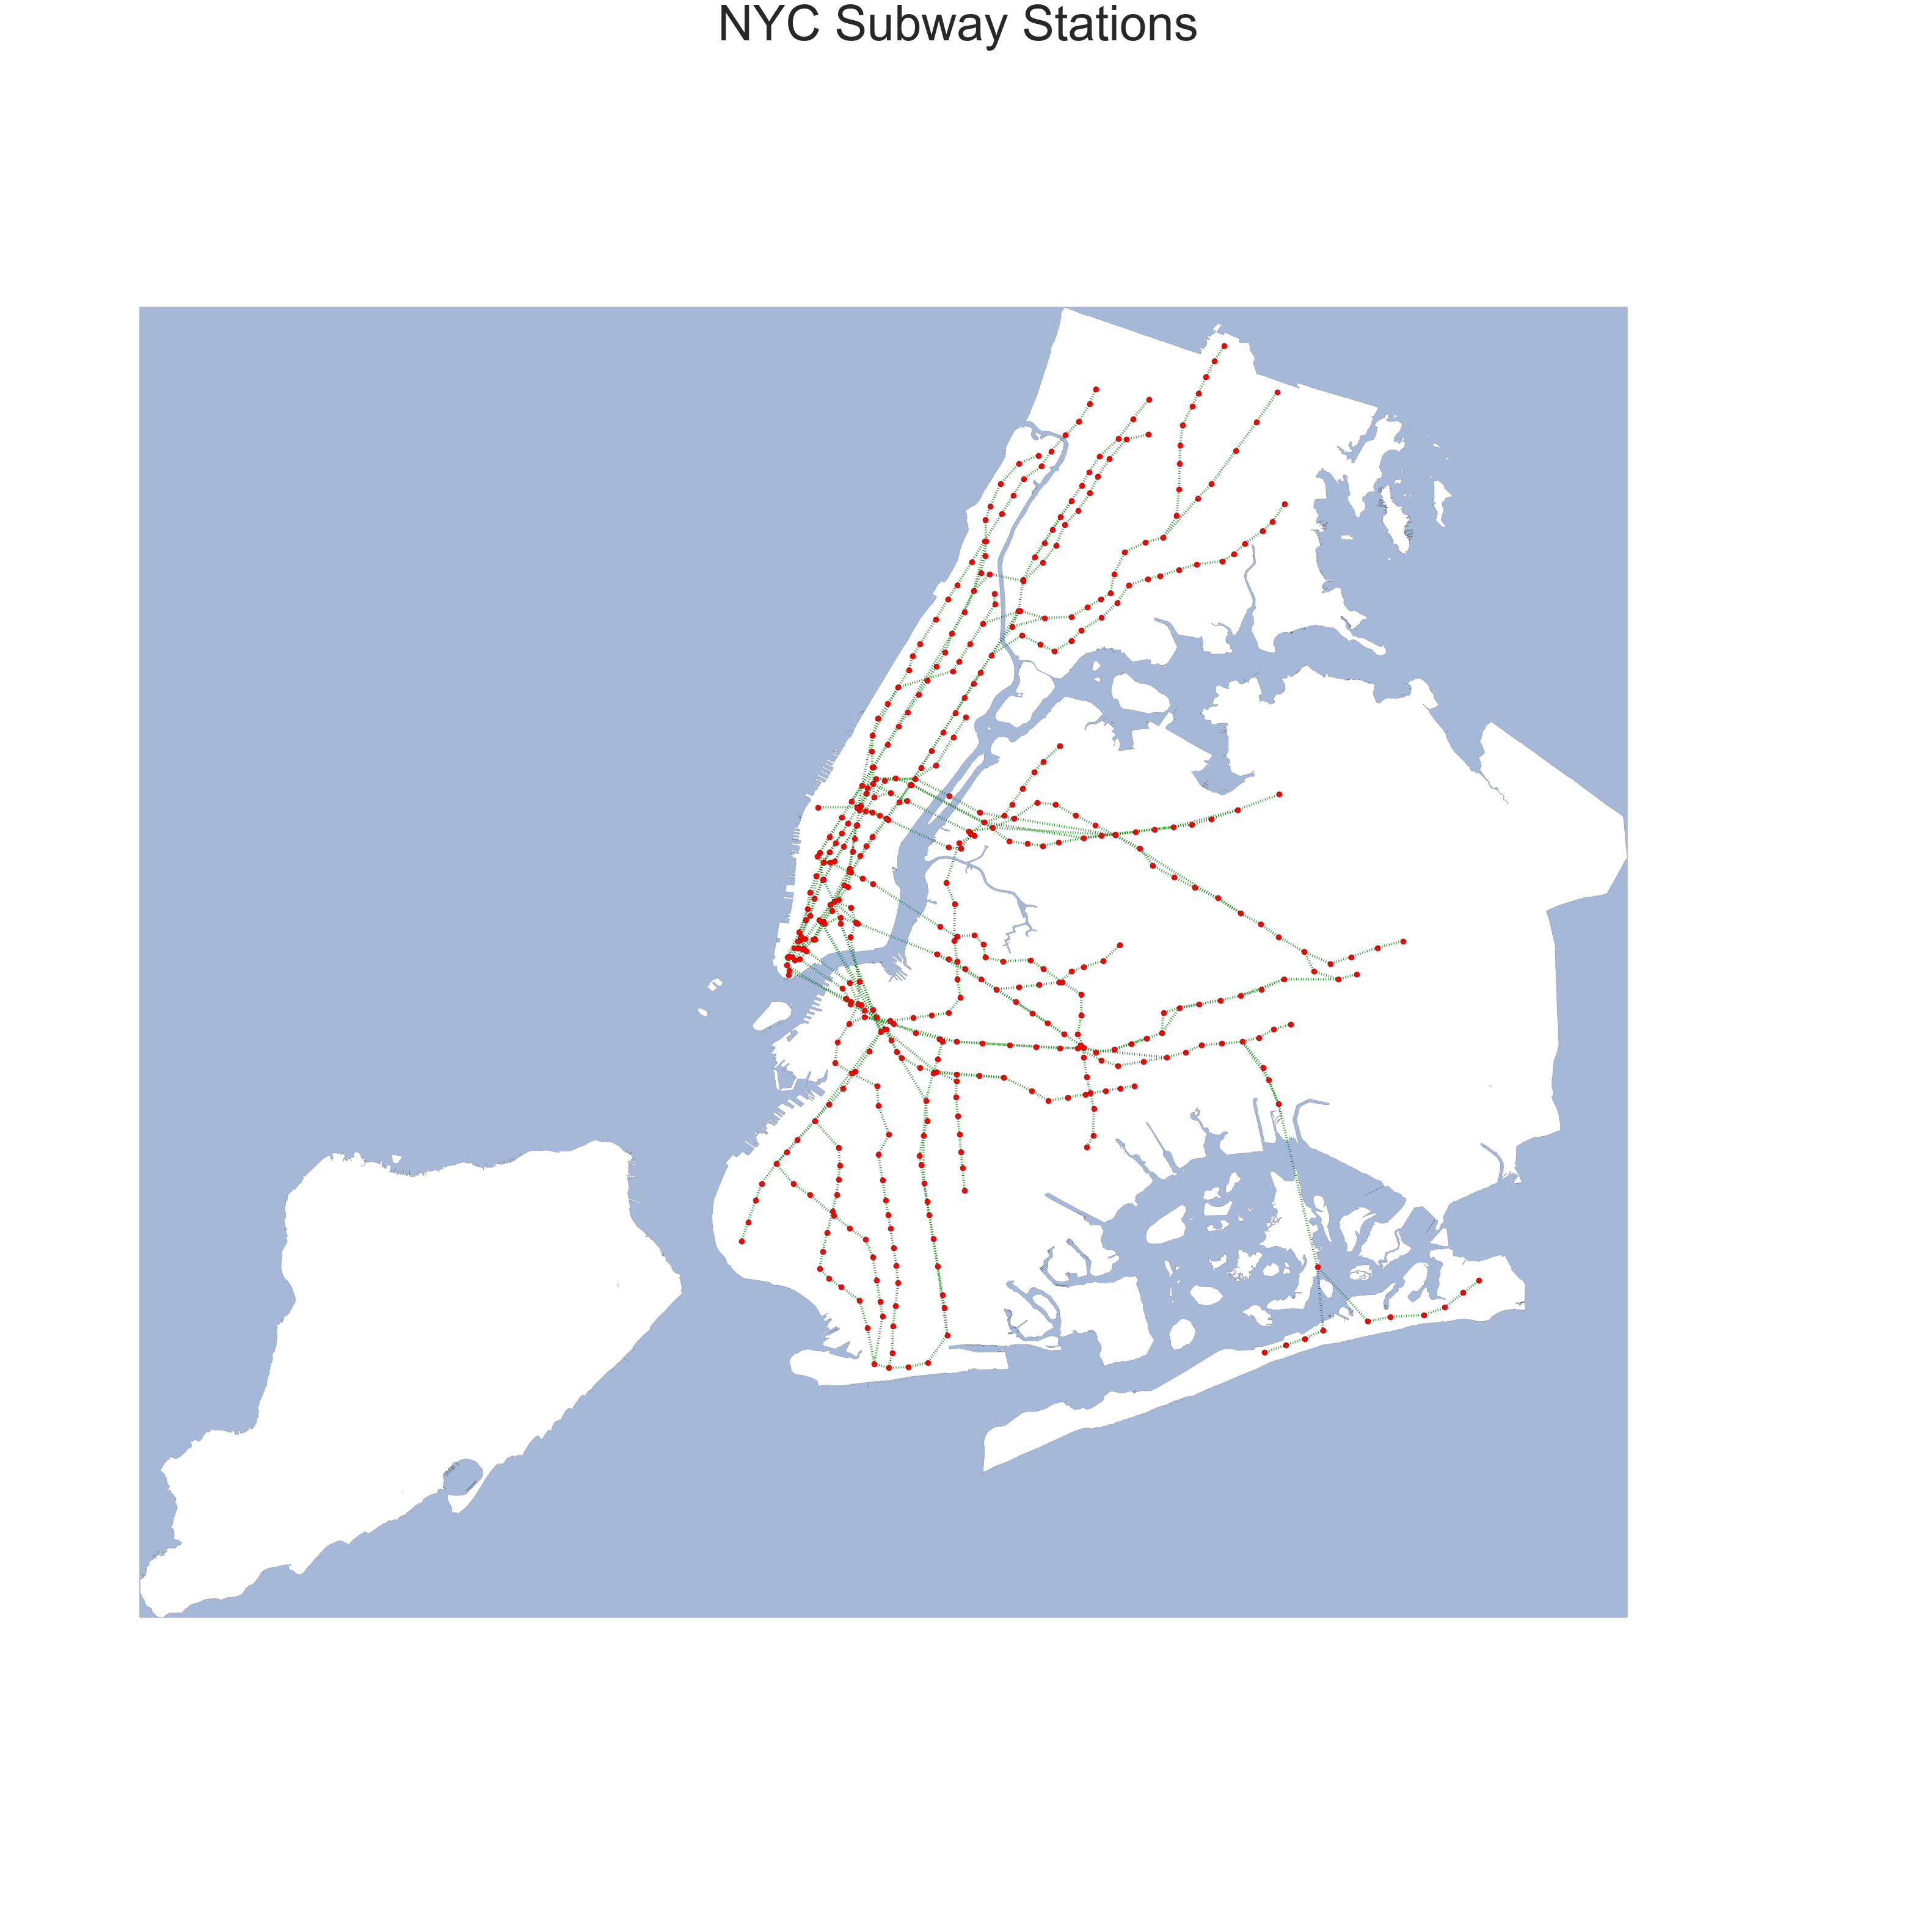

In [121]:
f, ax = plt.subplots(figsize=(55,55))
for polygon in un:

    patch = PolygonPatch(polygon, alpha=0.5, zorder=2)
    ax.add_patch(patch)
#sns.jointplot(x="longitude", y="latitude", data=gdf, kind="kde", size=24,ax=ax)

#f, ax = pl.subplots(figsize=(15,12))
pl.axis('off')

nx.draw(G,pos=stationpos,with_labels=False,node_size=85,style='dotted',edge_color='green', width=4)
pl.title("NYC Subway Stations", size=80)